In [1]:
# Install library yang diperlukan
!pip install tensorflow tensorflowjs
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found exis

In [2]:
import os
import zipfile
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paksa load gambar yang rusak
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# Upload kaggle.json
from google.colab import files
files.upload()

# Pindahkan kaggle.json ke ~/.kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d ismail703/insects

# Ekstrak dataset
with zipfile.ZipFile("insects.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

# Hapus zip file agar tidak memenuhi storage
os.remove("insects.zip")



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ismail703/insects
License(s): unknown


In [4]:
def test_open_images(directory):
    failed_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    img.load()
            except Exception as e:
                failed_images.append(img_path)
                print(f"Corrupted: {img_path}, Error: {e}")

    print(f"Total undetected corrupted images: {len(failed_images)}")
    return failed_images

# Cek semua gambar dalam dataset
failed_images = test_open_images("dataset")
for img_path in failed_images:
    os.remove(img_path)
    print(f"Removed: {img_path}")


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Total undetected corrupted images: 0


In [5]:
def convert_transparent_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    if img.mode == 'P' or img.mode == 'RGBA':  # Cek jika ada transparansi
                        img = img.convert('RGB')
                        img.save(img_path)
            except:
                pass

convert_transparent_images("dataset")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
# Buat folder untuk train, val, dan test
base_dir = "insects_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Bagi dataset 80% train, 10% val, 10% test
def split_data(source, train_dir, val_dir, test_dir, split_ratio=(0.8, 0.1, 0.1)):
    for category in os.listdir(source):
        category_path = os.path.join(source, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            random.shuffle(images)

            train_count = int(len(images) * split_ratio[0])
            val_count = int(len(images) * split_ratio[1])

            train_images = images[:train_count]
            val_images = images[train_count:train_count + val_count]
            test_images = images[train_count + val_count:]

            # Create subdirectories for categories in train, val, and test directories
            os.makedirs(os.path.join(train_dir, category), exist_ok=True)
            os.makedirs(os.path.join(val_dir, category), exist_ok=True)
            os.makedirs(os.path.join(test_dir, category), exist_ok=True)

            for img in train_images:
                shutil.move(os.path.join(category_path, img), os.path.join(train_dir, category, img))
            for img in val_images:
                shutil.move(os.path.join(category_path, img), os.path.join(val_dir, category, img))
            for img in test_images:
                shutil.move(os.path.join(category_path, img), os.path.join(test_dir, category, img))

split_data("dataset", train_dir, val_dir, test_dir)

In [12]:
import os
print(os.listdir("insects_data/train/Wasp/"))  # Cek apakah file sudah ada di lokasi lain


['Wasp_605.jpg', 'Wasp_95.jpg', 'Wasp_634.jpg', 'Wasp_781.jpg', 'Wasp_414.jpg', 'Wasp_147.jpeg', 'Wasp_527.jpg', 'Wasp_149.jpg', 'Wasp_310.jpg', 'Wasp_525.jpg', 'Wasp_816.jpg', 'Wasp_191.jpg', 'Wasp_680.jpg', 'Wasp_455.jpg', 'Wasp_687.jpg', 'Wasp_703.jpg', 'Wasp_260.jpg', 'Wasp_258.jpg', 'Wasp_183.jpg', 'Wasp_77.jpg', 'Wasp_325.jpg', 'Wasp_693.jpeg', 'Wasp_226.jpg', 'Wasp_105.jpg', 'Wasp_54.jpg', 'Wasp_294.png', 'Wasp_402.jpg', 'Wasp_125.jpg', 'Wasp_400.jpg', 'Wasp_71.jpg', 'Wasp_291.jpg', 'Wasp_679.jpg', 'Wasp_773.jpg', 'Wasp_704.jpg', 'Wasp_140.jpeg', 'Wasp_752.jpg', 'Wasp_587.jpg', 'Wasp_710.jpg', 'Wasp_656.jpg', 'Wasp_232.jpg', 'Wasp_427.jpg', 'Wasp_690.jpg', 'Wasp_452.jpg', 'Wasp_474.jpg', 'Wasp_314.jpeg', 'Wasp_624.jpg', 'Wasp_111.jpg', 'Wasp_424.jpg', 'Wasp_9.jpg', 'Wasp_756.jpg', 'Wasp_694.jpg', 'Wasp_221.jpg', 'Wasp_116.jpg', 'Wasp_419.jpg', 'Wasp_320.jpg', 'Wasp_352.jpg', 'Wasp_629.jpg', 'Wasp_673.jpg', 'Wasp_145.jpg', 'Wasp_465.jpg', 'Wasp_514.jpg', 'Wasp_102.jpg', 'Wasp_70.

In [13]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')


Found 6880 images belonging to 11 classes.
Found 856 images belonging to 11 classes.
Found 869 images belonging to 11 classes.


In [14]:
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,944,459 (49.38 MB)

 Trainable params: 12,944,459 (49.38 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stopping, reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
173/215 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.2382 - loss: 2.2164

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


215/215 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.2627 - loss: 2.1469 - val_accuracy: 0.5479 - val_loss: 1.2957 - learning_rate: 0.0010
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5719 - loss: 1.2598 - val_accuracy: 0.6799 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.6915 - loss: 0.9340 - val_accuracy: 0.7278 - val_loss: 0.8244 - learning_rate: 0.0010
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.7720 - loss: 0.6869 - val_accuracy: 0.7956 - val_loss: 0.6482 - learning_rate: 0.0010
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.8174 - loss: 0.5461 - val_accuracy: 0.8154 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.8831 - loss: 0.3557 - val_accuracy: 0.8236 - val_loss: 0.5800 - learning_rate: 0.0010
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9173 - loss: 0.2562 - val_

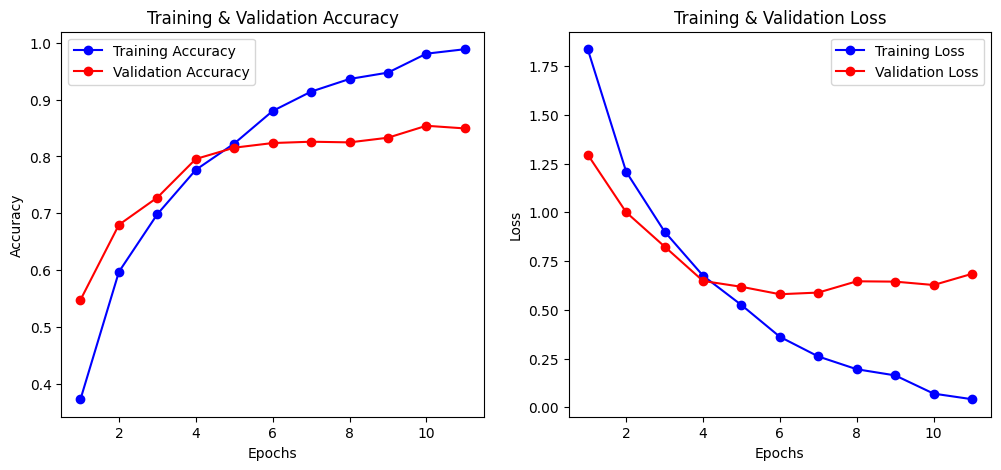

In [17]:
import matplotlib.pyplot as plt

# Ambil history training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

In [24]:
# Simpan model dalam format SavedModel
export_dir = 'saved_model/my_model'
tf.saved_model.save(model, export_dir)

# Konversi model ke TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='dense_2' saved_model/my_model ./tfjs_model


2025-03-21 20:27:58.554556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742588878.583280   25125 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742588878.591940   25125 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742588878.615165   25125 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742588878.615221   25125 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742588878.615226   25125 computation_placer.cc:177] computation placer alr

In [32]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Ukuran gambar yang digunakan dalam pelatihan
IMG_SIZE = (128, 128)

# Mapping class berdasarkan indeks pelatihan
class_indices = {'Ant': 0, 'Bee': 1, 'Beetle': 2, 'Butterfly': 3, 'Dragonfly': 4,
                 'Fly': 5, 'Grasshopper': 6, 'Ladybug': 7, 'Mosquito': 8, 'Spider': 9, 'Wasp': 10}
label_map = {v: k for k, v in class_indices.items()}

def predict_image(img_path, model):
    """Fungsi untuk memprediksi gambar menggunakan model yang sudah dilatih"""
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    return label_map[predicted_class], prediction[0][predicted_class]

# Contoh penggunaan
img_path = input("Masukkan path gambar: ")
predicted_label, confidence = predict_image(img_path, model)
print(f"Prediksi: {predicted_label} dengan keyakinan {confidence:.2f}")


Masukkan path gambar: /content/bee.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediksi: Bee dengan keyakinan 0.81


In [27]:
from google.colab import files
import shutil

shutil.make_archive('tfjs_model', 'zip', '/content/tfjs_model')
files.download('tfjs_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
files.download('/content/model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
shutil.make_archive('saved_model', 'zip', '/content/saved_model')
files.download('saved_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
pip freeze > requirements.txt